# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import gc   
import warnings
warnings.filterwarnings('ignore')

# 2. Load Clean Dataset

In [2]:
df = pd.read_csv("/kaggle/input/clean-nids-dataset/clean_nids.csv")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,...,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Label
0,22,1266342,41,44,2664,6954,0,109.864573,0,312.675250,...,0,0,1,29200,243,24,32,0.0,0.0,5
1,22,1319353,41,44,2664,6954,0,109.864573,0,312.675250,...,0,0,1,29200,243,24,32,0.0,0.0,5
2,22,160,1,1,0,0,0,0.000000,0,0.000000,...,1,1,1,290,243,0,32,0.0,0.0,5
3,22,1303488,41,42,2728,6634,0,110.129945,0,319.121427,...,0,0,1,29200,243,24,32,0.0,0.0,5
4,35396,77,1,2,0,0,0,0.000000,0,0.000000,...,1,1,2,243,290,0,32,0.0,0.0,5


# 3. Keeping Label in Y (Separating from the features X)

In [3]:
X = df.drop(columns=['Label'])
y = df['Label']
print(f"Shape: {df.shape}")

Shape: (2520798, 34)


# 4. Splitting (20/80)

In [4]:
X = df.drop(columns=['Label'])
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y 
)
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

Train Shape: (2016638, 33)
Test Shape:  (504160, 33)


# 5. Applying RFC to select top 20 Features

In [5]:
X_sample = X_train.sample(frac=0.10, random_state=42)
y_sample = y_train.loc[X_sample.index]  
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_sample, y_sample)  
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_20_features = importances.nlargest(20)
top_20_list = top_20_features.index.tolist()  
importance_df = pd.DataFrame({
    'Rank': range(1, 21),
    'Feature Name': top_20_features.index,
    'Importance Score': top_20_features.values
})
print("\nTop 20 Features & Their Importance Scores:")
print("-" * 65)
print(f"{'Rank':<5} | {'Feature Name':<40} | {'Score'}")
print("-" * 65)
for index, row in importance_df.iterrows():
    print(f"{int(row['Rank']):<5} | {row['Feature Name']:<40} | {row['Importance Score']:.6f}")
print("-" * 65)


Top 20 Features & Their Importance Scores:
-----------------------------------------------------------------
Rank  | Feature Name                             | Score
-----------------------------------------------------------------
1     | Bwd Packet Length Std                    | 0.123785
2     | Total Length of Bwd Packets              | 0.102889
3     | Flow IAT Std                             | 0.075549
4     | Fwd IAT Std                              | 0.068922
5     | Total Length of Fwd Packets              | 0.067634
6     | Destination Port                         | 0.048299
7     | Init_Win_bytes_backward                  | 0.046292
8     | Total Fwd Packets                        | 0.045609
9     | Bwd Packets/s                            | 0.043785
10    | Fwd Packet Length Std                    | 0.038489
11    | Flow Packets/s                           | 0.037344
12    | PSH Flag Count                           | 0.032890
13    | Init_Win_bytes_forward                 

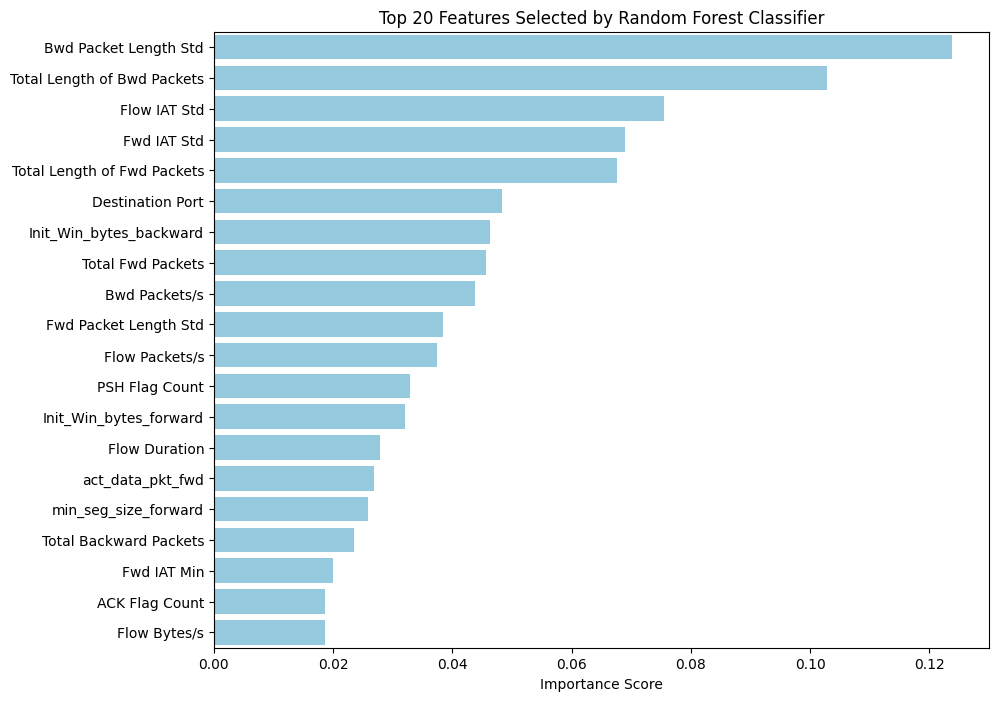

In [13]:
plt.figure(figsize=(10, 8)) 
sns.barplot(
    x=top_20_features.values, 
    y=top_20_features.index, 
    color='skyblue'
)
plt.title("Top 20 Features Selected by Random Forest Classifier")
plt.xlabel("Importance Score")
plt.show()

In [7]:
X_train = X_train[top_20_list]
X_test = X_test[top_20_list]
print(f"New Feature Count: {X_train.shape[1]}")

New Feature Count: 20


# 6. Data Distribution

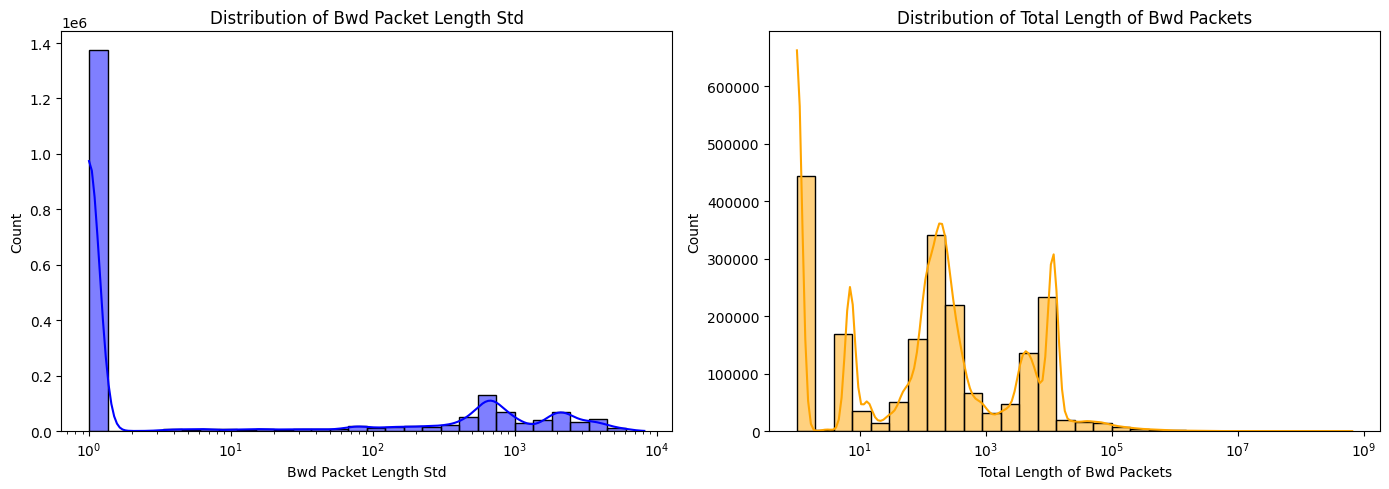

In [8]:
feature_1 = top_20_list[0]
feature_2 = top_20_list[1]
plt.figure(figsize=(14, 5)) 
plt.subplot(1, 2, 1) 
sns.histplot(X_train[feature_1] + 1, bins=30, kde=True, color='blue', log_scale=True) 
plt.title(f"Distribution of {feature_1}") 
plt.subplot(1, 2, 2) 
sns.histplot(X_train[feature_2] + 1, bins=30, kde=True, color='orange', log_scale=True)
plt.title(f"Distribution of {feature_2}")
plt.tight_layout()
plt.show()

# 7. Normalization (MinMax Scaling)

In [14]:
scaler = MinMaxScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns) 
print(f"Max Value in Train: {X_train.max().max()}")
print(f"Min Value in Train: {X_train.min().min()}")

Max Value in Train: 1.0000000000000002
Min Value in Train: 0.0


In [15]:
max_val = X_train.max().max() 
is_one = np.isclose(max_val, 1.0)
print(f"Is the value effectively 1.0? -> {is_one}")

Is the value effectively 1.0? -> True


# 8. Saving Train and Test CSVs

In [16]:
train_final = X_train.copy()
train_final['Label'] = y_train.reset_index(drop=True)
test_final = X_test.copy()
test_final['Label'] = y_test.reset_index(drop=True)
train_final.to_csv('train_nids.csv', index=False)
test_final.to_csv('test_nids.csv', index=False)
print("1. train_nids.csv Saved")
print(f"Train Shape: {train_final.shape}")
print("2. test_nids.csv Saved")  
print(f"Test Shape:  {test_final.shape}")   

1. train_nids.csv Saved
Train Shape: (2016638, 21)
2. test_nids.csv Saved
Test Shape:  (504160, 21)
